Here’s the list of preprocessing steps in simple terms:

1. **Convert the target to binary**: Change the `state` column into two categories: "successful" (1) and "not successful" (0).  
2. **Convert date columns**: Turn `launched` and `deadline` into useful numbers like campaign length and launch month.  
3. **Log-transform the `goal` column**: Shrink large values in the `goal` column to make them easier to handle.  
4. **Encode categorical columns**: Change text categories (like "Art" or "USD") into numbers the model can understand.  
5. **Normalize numerical features**: Scale numbers (like `goal` and campaign length) to a smaller range for consistency.  
6. **Split the dataset**: Divide the data into training and test sets to evaluate the model later.  



In [2]:
import pandas as pd

In [3]:
import numpy as np 

In [4]:
from sklearn.preprocessing import LabelEncoder 

In [5]:
from sklearn.preprocessing import MinMaxScaler 

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('ks-projects-201801.csv')

In [8]:
# Convert target 'state' to binary: 1 for successful, 0 for others
df['state'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)


In [9]:
# Convert 'launched' and 'deadline' to datetime
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])

In [10]:
# Create new features from datetime columns
df['launch_year'] = df['launched'].dt.year
df['launch_month'] = df['launched'].dt.month
df['launch_day'] = df['launched'].dt.day
df['campaign_length'] = (df['deadline'] - df['launched']).dt.days

In [11]:
# Log-transform 'goal' to reduce skewness
# The goal column (the amount of money the project aims to raise) often has very large values that can skew the data.
# For example, if most projects aim for $1,000 but some aim for $1,000,000, it could distort the analysis.
# By applying a log transformation, we "compress" the range of values, making it easier for the model to learn patterns.

df['goal'] = np.log1p(df['goal'])

In [12]:
# Encode categorical columns using LabelEncoder
#Since neural networks work with numbers, we convert these into numerical values using Label Encoding.
encoder = LabelEncoder()
categorical_columns = ['category', 'main_category', 'currency', 'country']
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

In [13]:
# Normalize numerical features using MinMaxScaler
# Columns like goal and campaign_length have values that can vary widely (e.g., one project’s goal might be $100, another $10,000).
# To ensure all features have similar importance, we scale them to a smaller range (e.g., 0 to 1). This helps the neural network train better.
scaler = MinMaxScaler()
numerical_columns = ['goal', 'campaign_length']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [14]:
# Split data into features (X) and target (y)
X = df.drop(columns=['state'])
y = df['state']

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (302928, 18)
Test set size: (75733, 18)


*EDA*



1. **Analyzed the target variable distribution**:
   - Checked the counts of different states (e.g., successful vs. unsuccessful campaigns) using a count plot.

2. **Explored the distribution of the 'goal' variable**:
   - Plotted the original and log-transformed goal values to understand the data's skewness and transformation effect.

3. **Calculated and visualized category-wise success rates**:
   - Grouped campaigns by their main category and plotted the success rate for each category.

4. **Analyzed campaign length vs. success**:
   - Used a boxplot to compare the lengths of campaigns across success and failure states.

5. **Examined success rates by launch month**:
   - Grouped campaigns by the month they were launched and plotted the success rate for each month.

6. **Created a correlation heatmap**:
   - Checked relationships between numeric features and their strength using a heatmap. 



In [16]:
import seaborn as sns  
import matplotlib.pyplot as plt  


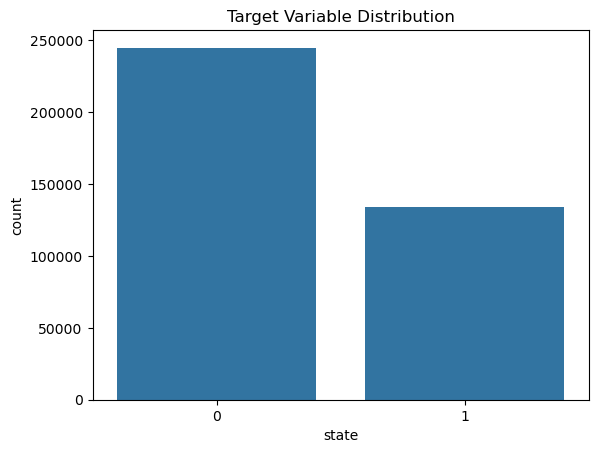

In [17]:
# Target variable distribution
#Check how many projects succeeded vs. failed to understand the balance of the target column.
sns.countplot(x='state', data=df)
plt.title('Target Variable Distribution')
plt.show()

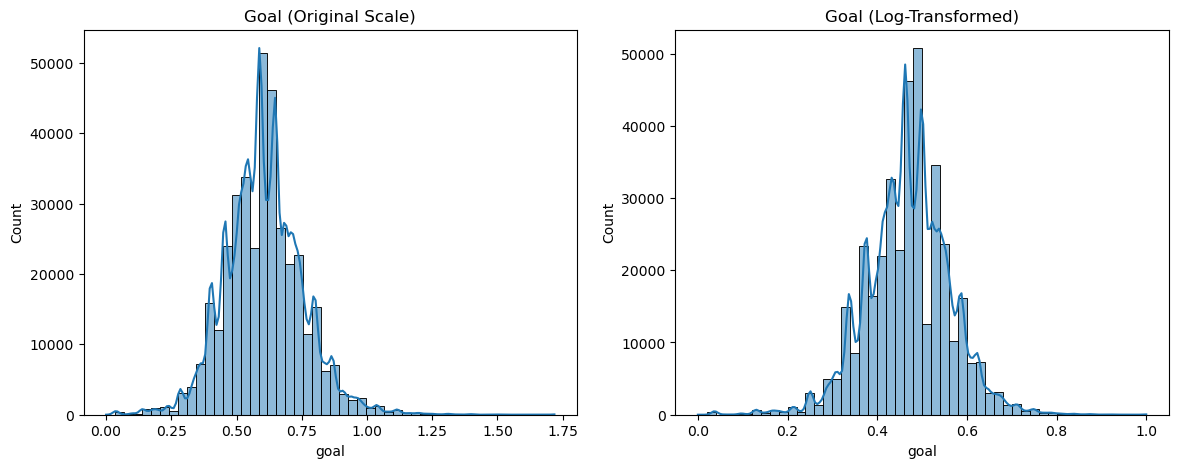

In [18]:
# Distribution of 'goal' before and after log transformation
#Compares the original goal values to the log-transformed ones.
# Helps check if applying a log transformation makes the data easier to work with.
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(np.expm1(df['goal']), bins=50, kde=True)
plt.title('Goal (Original Scale)')
plt.subplot(1, 2, 2)
sns.histplot(df['goal'], bins=50, kde=True)
plt.title('Goal (Log-Transformed)')
plt.show()

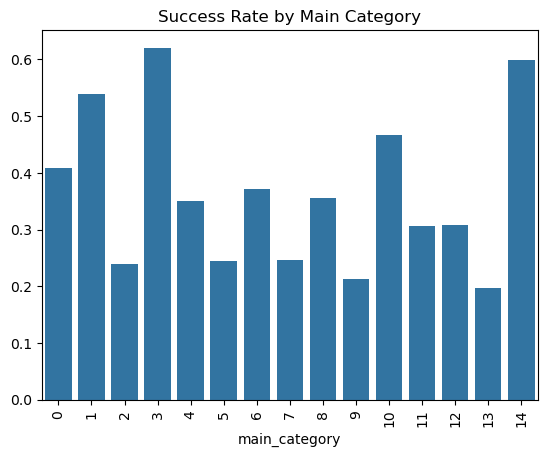

In [19]:
# Category success rate
# Shows success rates for each campaign category.
# Helps you see which categories are more successful than others.
category_success_rate = df.groupby('main_category')['state'].mean().sort_values(ascending=False)
sns.barplot(x=category_success_rate.index, y=category_success_rate.values)
plt.title('Success Rate by Main Category')
plt.xticks(rotation=90)
plt.show()

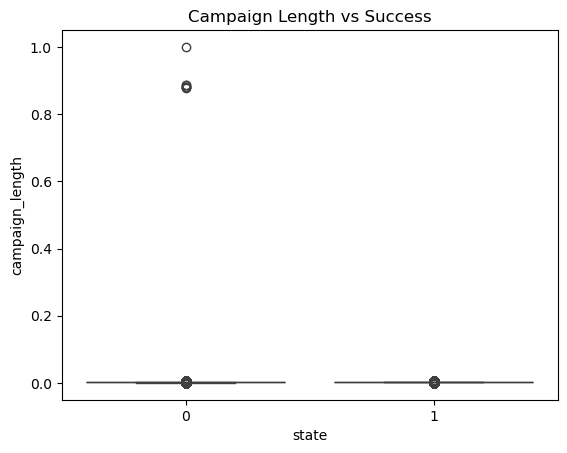

In [20]:
# Campaign length vs. success
#Compares campaign length with success or failure.
# Helps you understand if longer or shorter campaigns do better.
sns.boxplot(x='state', y='campaign_length', data=df)
plt.title('Campaign Length vs Success')
plt.show()

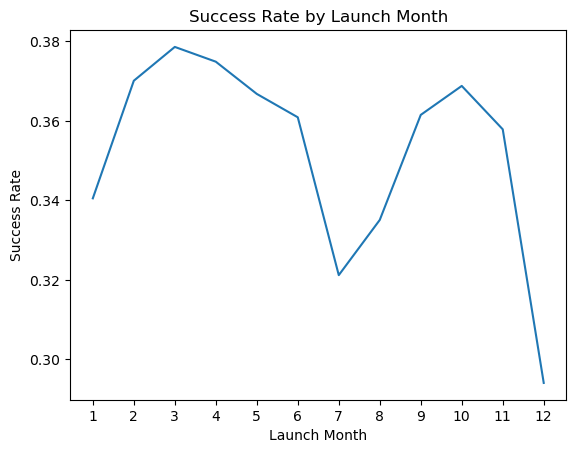

In [21]:
# Launch month vs. success rate
# Shows success rates by the month campaigns were launched.
# Helps identify which months are better for campaign success.
launch_month_success_rate = df.groupby('launch_month')['state'].mean()
sns.lineplot(x=launch_month_success_rate.index, y=launch_month_success_rate.values)
plt.title('Success Rate by Launch Month')
plt.xlabel('Launch Month')
plt.ylabel('Success Rate')
plt.xticks(range(1, 13))
plt.show()

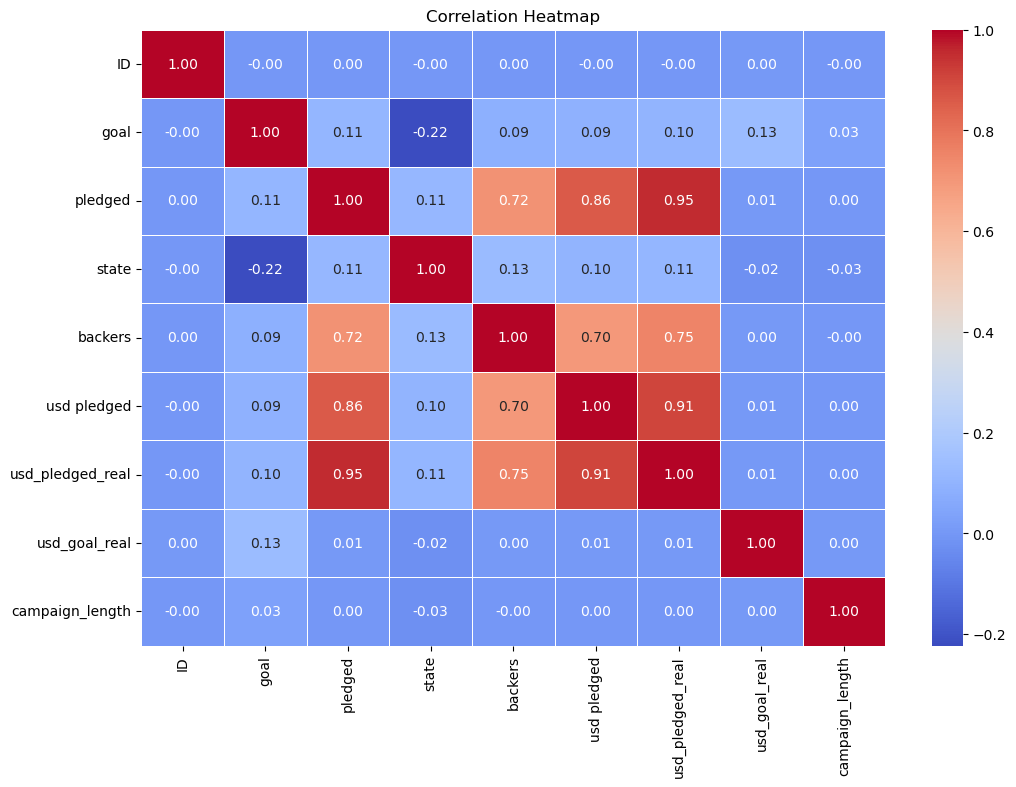

In [22]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
# Shows how different features are related to each other.
# Helps you see if some features are strongly connected, which can guide modeling decisions.
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [23]:
# Assuming your dataset is loaded into a DataFrame named `df`
columns = df.columns
print(columns)


Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launch_year',
       'launch_month', 'launch_day', 'campaign_length'],
      dtype='object')


**Feature Engineering**

1. Finding the common start date of each project and the length of them 

In [24]:
df['day_of_week'] = df['launched'].dt.dayofweek
df['campaign_length'] = (df['deadline'] - df['launched']).dt.days


 2.Normalize 'goal' and 'usd_goal_real' so they're on the same scale, this prevents any one feature from overpowering others due to its larger size

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['goal', 'usd_goal_real']] = scaler.fit_transform(df[['goal', 'usd_goal_real']])

3. multiplying 'goal' by 'launch_month' to explore potential seasonal effects on funding goals
This could show trends like higher funding goals in certain months due to seasonality

In [26]:
df['goal_times_launch_month'] = df['goal'] * df['launch_month']

Remove outliers in the 'goal' column by filtering out values more than 3 standard deviations from the mean which ensures the analysis is not skewed by extreme values

this is to avoid very large numbers 

In [31]:
from scipy import stats

In [32]:

df = df[(np.abs(stats.zscore(df['goal'])) < 3)]